In [5]:
import pandas as pd
import numpy as np 
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Creating datasets

In [6]:
# BELOW IS RAW DAILY DATA
all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\daily_deaths.csv")
all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\daily_infections.csv")
all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

deaths = all_county_deaths.rename(columns={'confirmed': 'Deaths'})
infected = all_county_infected.rename(columns={'confirmed': 'Infected'})

merged_df = pd.merge(infected, deaths, on='date', how='outer')

title = 'Simulation 1'

gamma = 0.15  # recovery rate
delta = 0.001 # death rate

In [7]:
# # BELOW IS RAW WEEKLY DATA
# all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\weekly_deaths.csv")
# all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

# all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\weekly_infections.csv")
# all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

# deaths = all_county_deaths.rename(columns={'confirmed': 'Deaths'})
# infected = all_county_infected.rename(columns={'confirmed': 'Infected'})

# merged_df = pd.merge(infected, deaths, on='date', how='outer')
# title = 'Simulation 2'

# gamma = 1  # recovery rate
# delta = 140 # death rate

In [8]:
# # BELOW IS 7 day rolling
# all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\daily_deaths.csv")
# all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

# all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\7_day_rolling_infections.csv")
# all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

# deaths = all_county_deaths.rename(columns={'confirmed': 'Deaths'})
# infected = all_county_infected.rename(columns={'confirmed': 'Infected'})

# merged_df = pd.merge(infected, deaths, on='date', how='outer')

# gamma = 0.15  # recovery rate
# delta = 2/210 # death rate
# title = 'Simulation 1'

In [9]:
all_county_exemption_rates = pd.read_excel(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used - OLD\exemption_rates.xlsx")
all_county_population = pd.read_excel(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used - OLD\county_size_N.xlsx")

In [10]:
efficacy = 0.95 # measles vaccine efficacy (average of cdc stats for 1 and 2 doses)
county_name = 'Texas'

deaths = all_county_deaths.set_index('date')
infected = all_county_infected.set_index('date')

exemption = all_county_exemption_rates[all_county_exemption_rates['County'] == county_name]
exemption_val = float(exemption['Exemption Rate'].values[0])

population = all_county_population[all_county_population['County'] == county_name]
pop_val = int(population['Population'].values[0])

# calculate population N to make closed system S + I + R + D = N
N = pop_val*(1-(1-exemption_val)*efficacy)
# N = pop_val
print(N)


2272222.654181933


In [97]:
# # merged_df = pd.concat([infected.rename("Infected"),
# #                        deaths.rename("Deaths")], axis=1)

# # merged_df = merged_df.reset_index().rename(columns={'index': 'Date'})
# merged_df = pd.merge(infected, deaths, on='date', how='outer')

# print(merged_df.head())

# ENKF SETTING GAMMA AND DELTA CONSTNAT

In [ ]:

H = np.array([
    [0, 1, 0],  # I
    [0, 0, 1]   # D
])

n_ens = 500
dt = 1.0

alpha = 1.2
tol = 1e-3
ens_perturb = 0.2

beta_low, beta_high = 0, 0.5
gamma = 1
delta = 140
# gamma = 0.15
# delta = 0.001

# 0.2, 0.5, 0.01

# gamma = 0.15 # recovery rate 
# delta = 0.002

In [117]:
import numpy as np

# Initial states from observed data
I0 = int(merged_df['Infected'].iloc[0])
D0 = int(merged_df['Deaths'].iloc[0])
S0 = max(N - I0 - D0, 0)

x0_mean = np.array([S0, I0, D0])

# gamma and delta are fixed globally
gamma = 0.15
delta = 0.001

def R_from_obs(y_obs_k):
    y_safe = np.where(np.isnan(y_obs_k), 0.01, y_obs_k)
    std_devs = 0.1 * np.maximum(y_safe, 0.01)
    cov_matrix = np.diag(std_devs ** 2)
    cov_matrix += np.eye(len(y_obs_k)) * 1e-6
    return cov_matrix

def enforce_mass(state_ens, N):
    np.maximum(state_ens, 0.0, out=state_ens)
    total_IRD = state_ens[:, 1] + state_ens[:, 2]
    ok = total_IRD <= N
    state_ens[ok, 0] = N - total_IRD[ok]
    over = ~ok
    if np.any(over):
        scale = (N / total_IRD[over])[:, None]
        state_ens[over, 1:3] *= scale
        state_ens[over, 0] = 0.0
    return state_ens

def sird_step(state, N, day, dt):
    S, I, D, beta = state  # Only beta is in state vector, gamma and delta fixed globally
    dS = - beta * S * I / N
    dI = beta * S * I / N - gamma * I - delta * I
    dD = delta * I
    S_new = max(S + dS * dt, 0)
    I_new = max(I + dI * dt, 0)
    D_new = max(D + dD * dt, 0)

    beta_new = np.clip(beta + np.random.normal(0, 0.5), 0.0, 1.0)
    # gamma and delta fixed, so no update here
    return np.array([S_new, I_new, D_new, beta_new])

def predict_measurement(state_ensemble):
    # state_ensemble shape (n_ens, 4), columns: S, I, D, beta
    return state_ensemble[:, 1:3]

def clean_nans(actual, predicted):
    mask = ~np.isnan(actual) & ~np.isnan(predicted)
    return actual[mask], predicted[mask]

In [118]:
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np

def run_enkf_for_seed(sim_seed):
    rng = np.random.default_rng(sim_seed)

    n_ens = 500
    ens_perturb = 0.2
    alpha = 1.2
    tol = 1e-3

    # Initialize ensemble states shape (n_ens, 4)
    # [S, I, D, beta]
    state_ens = np.zeros((n_ens, 4))
    for i in range(n_ens):
        perturb = 1 + ens_perturb * rng.normal(size=2)
        ID = np.maximum(x0_mean[1:] * perturb, 0)
        S = max(N - ID.sum(), 0)
        beta = rng.uniform(beta_low, beta_high)
        state_ens[i] = np.array([S, ID[0], ID[1], beta])

    state_ens[:, 1] += I0
    n_timesteps = len(merged_df)
    ensemble_states_hist = np.full((n_timesteps, n_ens, 4), np.nan)

    max_passes = 10
    pass_idx = 0
    total_cycles = 0
    converged = False
    converged_day = None
    converg_counter = 0

    Y_obs = merged_df[['Infected', 'Deaths']].to_numpy()

    while pass_idx < max_passes and not converged:
        pass_idx += 1
        # Optional re-initialization each pass
        for i in range(n_ens):
            perturb = 1 + ens_perturb * rng.normal(size=2)
            ID = np.maximum(x0_mean[1:] * perturb, 0)
            S = max(N - ID.sum(), 0)
            beta = rng.uniform(beta_low, beta_high)
            state_ens[i] = np.array([S, ID[0], ID[1], beta])
        state_ens = enforce_mass(state_ens, N)

        converged_day = None

        for k in range(n_timesteps):
            total_cycles += 1
            # Forecast step
            for i in range(n_ens):
                state_ens[i] = sird_step(state_ens[i], N, k, dt)
            state_ens = enforce_mass(state_ens, N)

            # Parameter bounds after forecast
            state_ens[:, 3] = np.clip(state_ens[:, 3], 0.0, 1.0)

            ensemble_states_hist[k] = state_ens.copy()

            # Measurement prediction
            meas_pred = predict_measurement(state_ens)
            y_obs_k = Y_obs[k]
            y_obs_k = np.nan_to_num(y_obs_k, nan=1e-2)
            Rk = R_from_obs(y_obs_k)
            obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)

            # Kalman update
            aug_ens = state_ens.copy()
            aug_mean = np.mean(aug_ens, axis=0)
            meas_mean = np.mean(meas_pred, axis=0)
            X = aug_ens - aug_mean
            Y = meas_pred - meas_mean
            C_xy = (X.T @ Y) / (n_ens - 1)
            C_yy = (Y.T @ Y) / (n_ens - 1)
            Kk = C_xy @ np.linalg.inv(C_yy + Rk)

            for i in range(n_ens):
                innovation = obs_perturbed[i] - meas_pred[i]
                aug_update = aug_ens[i] + alpha * (Kk @ innovation)
                # Enforce parameter bounds after update
                aug_update[3] = np.clip(aug_update[3], 0.0, 1.0)
                # gamma and delta fixed and not updated
                state_ens[i] = aug_update
            state_ens = enforce_mass(state_ens, N)

            # Parameter bounds after update
            state_ens[:, 3] = np.clip(state_ens[:, 3], 0.0, 1.0)

            ensemble_states_hist[k] = state_ens.copy()
            print(f"Day {k}: I mean = {np.mean(state_ens[:,1]):.2f}, I std = {np.std(state_ens[:,1]):.2f}, True I = {Y_obs[k,0]:.2f}")

            # Check convergence only on beta parameter
            if k > 0:
                prev_mean_beta = np.mean(ensemble_states_hist[k - 1, :, 3])
                curr_mean_beta = np.mean(state_ens[:, 3])
                rel_change = abs(curr_mean_beta - prev_mean_beta) / (abs(prev_mean_beta) + 1e-9)
                if rel_change < tol:
                    converg_counter += 1
                    if converg_counter >= 1:
                        converged_day = k
                else:
                    converg_counter = 0

        # last_day = converged_day if converged_day is not None else n_timesteps - 1
        # mean_states = np.nanmean(ensemble_states_hist[: last_day + 1], axis=1)
        mean_states = np.nanmean(ensemble_states_hist, axis=1)
        
        if converged_day is not None:
            converged = True

    # Metrics
    # actual_I = Y_obs[: last_day + 1, 0]
    # actual_D = Y_obs[: last_day + 1, 1]
    actual_I = Y_obs[:, 0]
    actual_D = Y_obs[:, 1]
    pred_I = mean_states[:, 1]
    pred_D = mean_states[:, 2]

    actual_I, pred_I = clean_nans(actual_I, pred_I)
    actual_D, pred_D = clean_nans(actual_D, pred_D)

    rmse_I = np.sqrt(root_mean_squared_error(actual_I, pred_I))
    r2_I = r2_score(actual_I, pred_I)
    rmse_D = np.sqrt(root_mean_squared_error(actual_D, pred_D))
    r2_D = r2_score(actual_D, pred_D)

    return {
        'rmse_I': rmse_I,
        'r2_I': r2_I,
        'rmse_D': rmse_D,
        'r2_D': r2_D,
        'total_cycles': total_cycles,
        'converged_day': converged_day,
        'mean_states': mean_states
    }

In [119]:
# seeds = 11  # Adjust as needed
seeds = (10, 13)
results = []
for seed in seeds:
    res = run_enkf_for_seed(seed)
    results.append(res)

# res = run_enkf_for_seed(seeds)
# results.append(res)

# Extract metrics
total_cycles_list = [r['total_cycles'] for r in results]
rmse_I_list = [r['rmse_I'] for r in results]
r2_I_list = [r['r2_I'] for r in results]
rmse_D_list = [r['rmse_D'] for r in results]
r2_D_list = [r['r2_D'] for r in results]

print(f"Mean assimilation cycles: {np.mean(total_cycles_list):.2f} ± {np.std(total_cycles_list):.2f}")
print("Infected (I):   RMSE {:.2f} ± {:.2f} | R² {:.4f} ± {:.4f}".format(np.mean(rmse_I_list), np.std(rmse_I_list), np.mean(r2_I_list), np.std(r2_I_list)))
print("Deceased (D):   RMSE {:.2f} ± {:.2f} | R² {:.4f} ± {:.4f}".format(np.mean(rmse_D_list), np.std(rmse_D_list), np.mean(r2_D_list), np.std(r2_D_list)))


Day 0: I mean = 1.62, I std = 0.16, True I = 1.75
Day 1: I mean = 1.76, I std = 0.20, True I = 1.80
Day 2: I mean = 1.39, I std = 0.20, True I = 1.50
Day 3: I mean = 1.40, I std = 0.17, True I = 1.43
Day 4: I mean = 1.38, I std = 0.17, True I = 1.43
Day 5: I mean = 1.39, I std = 0.16, True I = 1.43
Day 6: I mean = 1.21, I std = 0.15, True I = 1.29
Day 7: I mean = 1.42, I std = 0.17, True I = 1.43
Day 8: I mean = 1.84, I std = 0.21, True I = 1.86
Day 9: I mean = 2.83, I std = 0.31, True I = 2.86
Day 10: I mean = 3.40, I std = 0.40, True I = 3.57
Day 11: I mean = 3.71, I std = 0.46, True I = 4.00
Day 12: I mean = 4.51, I std = 0.51, True I = 4.71
Day 13: I mean = 4.48, I std = 0.58, True I = 4.86
Day 14: I mean = 4.19, I std = 0.55, True I = 4.57
Day 15: I mean = 3.78, I std = 0.51, True I = 4.14
Day 16: I mean = 3.57, I std = 0.47, True I = 3.86
Day 17: I mean = 3.49, I std = 0.43, True I = 3.71
Day 18: I mean = 3.85, I std = 0.46, True I = 4.00
Day 19: I mean = 4.51, I std = 0.53, True

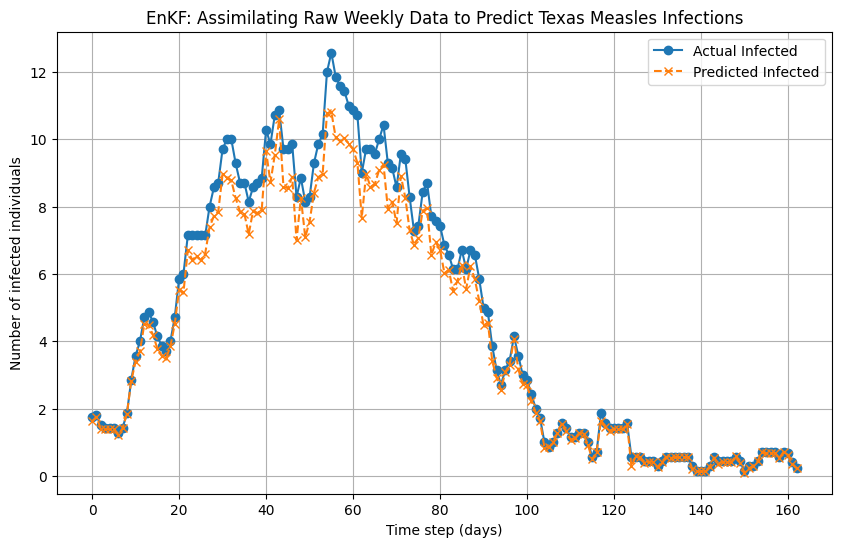

In [120]:
import matplotlib.pyplot as plt

mean_states = results[0]['mean_states']
pred_I = mean_states[:, 1]
actual_I = merged_df['Infected'].values[:len(pred_I)]

plt.figure(figsize=(10, 6))
plt.plot(actual_I, label='Actual Infected', linestyle='-', marker='o')
plt.plot(pred_I, label='Predicted Infected', linestyle='--', marker='x')
plt.xlabel('Time step (days)')
plt.ylabel('Number of infected individuals')
plt.title('EnKF: Assimilating Raw Weekly Data to Predict Texas Measles Infections')
plt.legend()
plt.grid(True)
plt.show()


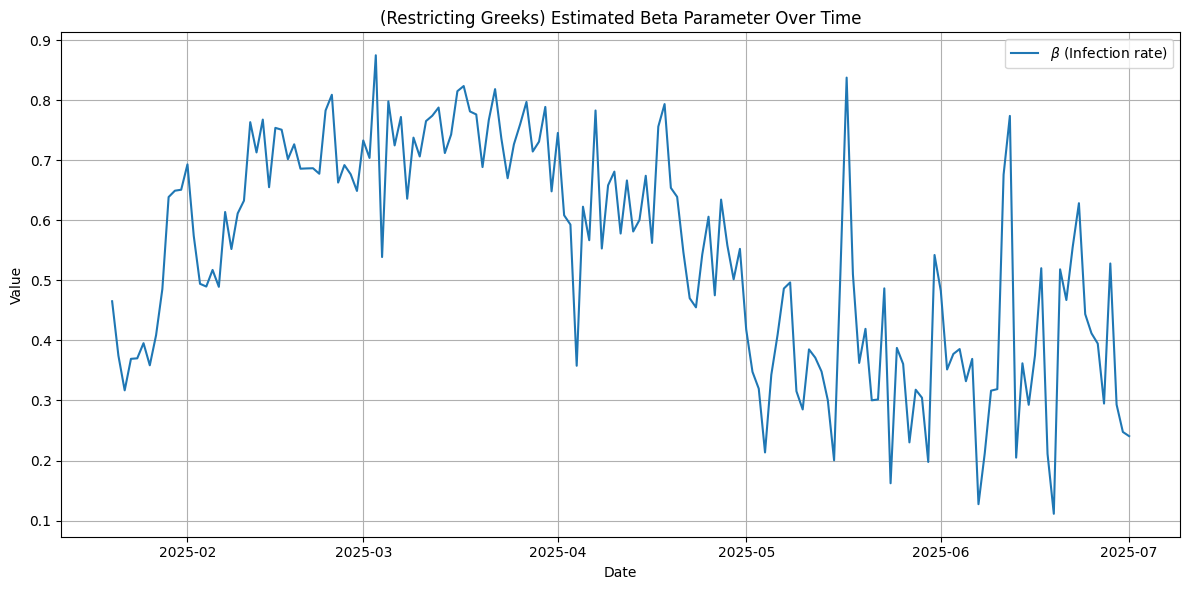

In [121]:
import matplotlib.pyplot as plt

def plot_beta_over_time(mean_states, dates):
    beta = mean_states[:, 3]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, beta, label=r'$\beta$ (Infection rate)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('(Restricting Greeks) Estimated Beta Parameter Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage example:
mean_states = results[0]['mean_states']
dates = merged_df['date'][:mean_states.shape[0]]
plot_beta_over_time(mean_states, dates)


# EKF 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score

# Fixed parameters


# Initialization from data:
D0 = int(merged_df['Deaths'].iloc[0])
I0 = float(merged_df['Infected'].iloc[0])
S0 = float(N - I0 - D0)

beta0 = 0.2  # initial guess for infection rate

# State vector: [S, I, D, beta]
x0 = np.array([S0, I0, D0, beta0], dtype=float)

# Covariance initialization for 4 states
P0 = np.diag([
    (0.05 * max(S0, 1.0))**2,
    (0.20 * max(I0, 1.0))**2,
    (0.20 * max(D0, 1.0))**2,
    1e-2,  # beta uncertainty
])

dt = 1.0
n_steps = len(merged_df)

# Measurement noise covariance (observing I and D)
R_cov = np.diag([0.05**2, 0.01**2])

# Dynamics function with fixed gamma, delta
def f_continuous(x, N):
    S, I, D, beta = x
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I - delta * I
    dD = delta * I
    dBeta = 0  # beta evolves as random walk, handled in Q
    return np.array([dS, dI, dD, dBeta])

# Process noise covariance
def compute_Q(x, N):
    S, I, D, beta = x
    p1 = max(beta * S * I / N, 0.0)
    p2 = max(gamma * I, 0.0)
    p3 = max(delta * I, 0.0)

    lam1 = np.array([-1, +1, 0, 0])
    lam2 = np.array([0, -1, 0, 0])
    lam3 = np.array([0, -1, +1, 0])

    Q_SID = (
        p1 * np.outer(lam1, lam1) +
        p2 * np.outer(lam2, lam2) +
        p3 * np.outer(lam3, lam3)
    )

    Q = np.zeros((4, 4))
    Q[:3, :3] += Q_SID[:3, :3]
    Q[3, 3] = 1e-6  # beta drift noise
    return Q

# Jacobian of f wrt x
def jacobian_F(x, N, dt):
    S, I, D, beta = x
    F = np.eye(4)

    F[0, 0] += -beta * I / N * dt
    F[0, 1] += -beta * S / N * dt
    F[0, 3] += -S * I / N * dt

    F[1, 0] += beta * I / N * dt
    F[1, 1] += (beta * S / N - gamma - delta) * dt
    F[1, 3] += S * I / N * dt

    F[2, 1] += delta * dt

    return F

# Observation and its Jacobian
def h(x, N):
    S, I, D, beta = x
    return np.array([I, D])

def jacobian_H(x, N):
    H = np.zeros((2, 4))
    H[0, 1] = 1  # dI/dI
    H[1, 2] = 1  # dD/dD
    return H

# Initialize arrays
x_est = np.zeros((4, n_steps))
P_est = np.zeros((4, 4, n_steps))
x_est[:, 0] = x0
P = P0

for k in range(1, n_steps):
    x_prev = x_est[:, k - 1].copy()
    P_prev = P.copy()

    # Predict step
    f_x = f_continuous(x_prev, N)
    x_pred = x_prev + f_x * dt
    F = jacobian_F(x_prev, N, dt)
    Q_k = compute_Q(x_prev, N)
    P_pred = F @ P_prev @ F.T + Q_k

    # Update step
    y_obs = merged_df[['Infected', 'Deaths']].iloc[k].to_numpy()
    y_obs_vec = np.array([y_obs[0], y_obs[1]])

    z_pred = h(x_pred, N)
    H = jacobian_H(x_pred, N)

    S_mat = H @ P_pred @ H.T + R_cov
    K = P_pred @ H.T @ np.linalg.inv(S_mat)
    innovation = y_obs_vec - z_pred

    x_upd = x_pred + K @ innovation
    x_upd = np.maximum(x_upd, 0.0)

    # Clip epidemiological parameters
    x_upd[3] = np.clip(x_upd[3], 0.0, 1.0)  # beta

    # Covariance update
    I4 = np.eye(4)
    P = (I4 - K @ H) @ P_pred @ (I4 - K @ H).T + K @ R_cov @ K.T

    x_est[:, k] = x_upd
    P_est[:, :, k] = P

# Extract estimates and actuals
S_est, I_est, D_est, beta_est = x_est
actual_I = merged_df['Infected'].to_numpy()
actual_D = merged_df['Deaths'].to_numpy()

# Metrics
rmse_I = root_mean_squared_error(actual_I, I_est)
r2_I = r2_score(actual_I, I_est)
rmse_D = root_mean_squared_error(actual_D, D_est)
r2_D = r2_score(actual_D, D_est)

print(f"RMSE(Infected): {rmse_I:.3f}, R²={r2_I:.4f}")
print(f"RMSE(Deaths):   {rmse_D:.3f}, R²={r2_D:.4f}")

RMSE(Infected): 0.194, R²=0.9982
RMSE(Deaths):   0.002, R²=0.9996


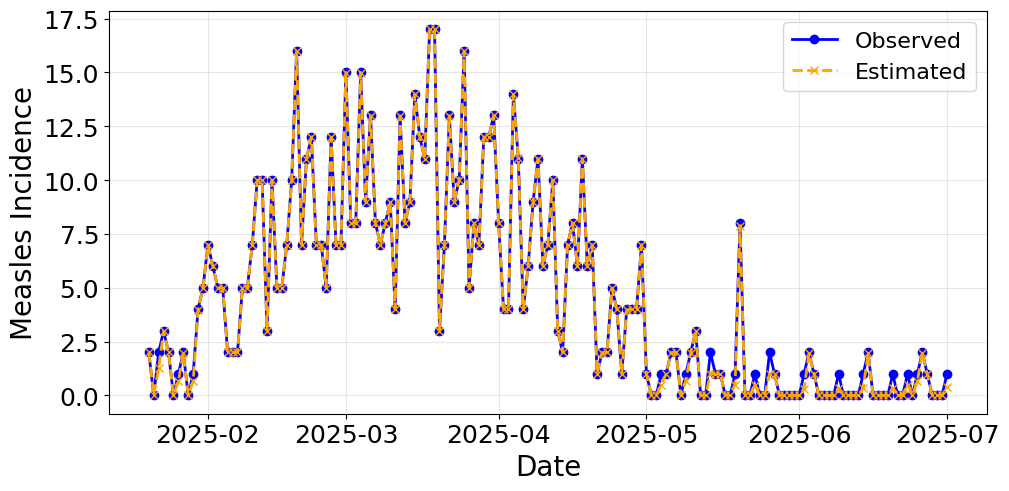

In [12]:
import matplotlib.pyplot as plt

# --- Font and layout settings ---
title_size = 24
axis_size = 20
x_label = 18
legend = 16

# --- Plot observed vs estimated infections ---
dates = merged_df['date']

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(dates, actual_I, 'o-', label="Observed", color='blue', linewidth=2, markersize=6)
ax.plot(dates, I_est, 'x--', label="Estimated", color='orange', linewidth=2, markersize=6)

ax.set_xlabel("Date", fontsize=axis_size)
ax.set_ylabel("Measles Incidence", fontsize=axis_size)
# ax.set_title(f"{title}:\nPredicted Infections vs Observed Infectious Cases", fontsize=title_size)

ax.tick_params(axis='both', labelsize=x_label)
ax.legend(fontsize=legend)
ax.grid(alpha=0.3)

plt.tight_layout()

# --- SAVE OPTIONS FOR POWERPOINT ---
# Option 1 (recommended): vector graphic — sharp at any zoom
plt.savefig("infection_plot.pdf", bbox_inches="tight")

# Option 2: editable vector (e.g., Illustrator, PowerPoint 365)
plt.savefig("infection_plot.svg", bbox_inches="tight")

# Option 3: high-resolution PNG for older PowerPoint versions or Canva
plt.savefig("infection_plot.png", dpi=600, bbox_inches="tight")

plt.show()

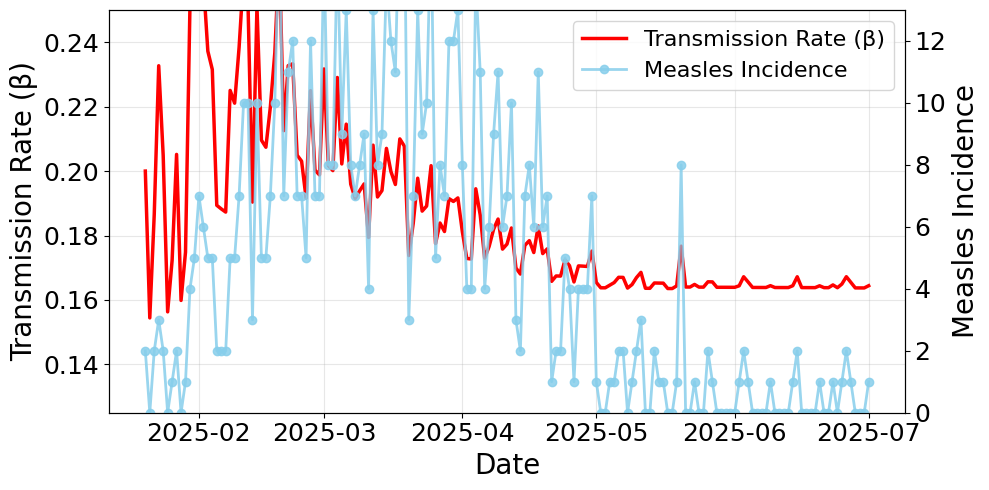

In [13]:
import matplotlib.pyplot as plt

# --- Font and style settings ---
title_size = 24
axis_size = 20
x_label = 18
legend = 16

dates = merged_df['date']

fig, ax1 = plt.subplots(figsize=(10, 5))

# --- Left y-axis: Transmission Rate (β) ---
if title == 'Simulation 2':
    ax1.plot(dates, beta_est / 7, color='red', linewidth=2.5, label='Transmission Rate (β)')
    ax1.set_xlabel("Date", fontsize=axis_size)
    ax1.set_ylabel("Transmission Rate (β)", fontsize=axis_size)
    ax1.set_ylim(0, 0.3)
    ax1.grid(alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(dates, actual_I, 'o-', color='skyblue', label='Measles Incidence',
             linewidth=2, markersize=6, alpha=0.85)
    ax2.set_ylabel("Observed Infected", fontsize=axis_size)
    ax2.set_ylim(0, 85)
    ax2.tick_params(axis='both', labelsize=x_label)

else:
    ax1.plot(dates, beta_est, color='red', linewidth=2.5, label='Transmission Rate (β)')
    ax1.set_xlabel("Date", fontsize=axis_size)
    ax1.set_ylabel("Transmission Rate (β)", fontsize=axis_size)
    ax1.set_ylim(0.125, 0.25)
    ax1.grid(alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(dates, actual_I, 'o-', color='skyblue', label='Measles Incidence',
             linewidth=2, markersize=6, alpha=0.85)
    ax2.set_ylabel("Measles Incidence", fontsize=axis_size)
    ax2.set_ylim(0, 13)
    ax2.tick_params(axis='both', labelsize=x_label)

# --- Combined legend (both y-axes) ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=legend)

# --- Layout and export ---
ax1.tick_params(axis='both', labelsize=x_label)
plt.tight_layout()

# --- SAVE OPTIONS FOR POWERPOINT ---
# Option 1 (best): vector graphic – stays razor-sharp
plt.savefig("transmission_vs_infection.pdf", bbox_inches="tight")

# Option 2: editable vector (works in Illustrator or PowerPoint 365)
plt.savefig("transmission_vs_infection.svg", bbox_inches="tight")

# Option 3: high-resolution PNG for Canva or older PowerPoint
plt.savefig("transmission_vs_infection.png", dpi=600, bbox_inches="tight")

plt.show()


In [14]:
print(beta_est)

[0.2        0.15443324 0.18659515 0.23269575 0.20491092 0.1563108
 0.17227477 0.20517209 0.159859   0.17482286 0.25164822 0.26277629
 0.28531679 0.25905389 0.2372233  0.23153833 0.18938007 0.18827097
 0.18727149 0.22504495 0.2210772  0.23837319 0.26071935 0.25175373
 0.19037709 0.25111251 0.20960958 0.20740483 0.21987987 0.23672233
 0.26755059 0.21253929 0.2327282  0.23330685 0.20493499 0.20307315
 0.19165334 0.22495608 0.20030202 0.1988094  0.23170019 0.2017009
 0.20015706 0.22905044 0.20222582 0.21456541 0.19595136 0.19147699
 0.19387773 0.19602504 0.17940634 0.20804795 0.19196149 0.19396127
 0.20705014 0.19988371 0.19583962 0.2099914  0.2077495  0.17379102
 0.18378234 0.19779594 0.18758033 0.18915441 0.20167095 0.17750277
 0.18387958 0.1812404  0.19146283 0.19057281 0.19167556 0.1811663
 0.17287965 0.17271538 0.19451091 0.18638848 0.17296804 0.17662123
 0.18196063 0.18511431 0.17578482 0.17733695 0.18234745 0.16992599
 0.16804723 0.17694157 0.17841671 0.17471686 0.18298768 0.1743963